# Information
## Source
This notebook prepares the data from Lawley et al. (2022) using the version from https://drive.google.com/file/d/1jyxbPmwhMEhgezxMTxwmKTuU1PhT9yPe using the original H3 hexagonal polygon data.

**Citaton**: <p>
Christopher J.M. Lawley, Anne E. McCafferty, Garth E. Graham, David L. Huston, Karen D. Kelley, Karol Czarnota, Suzanne Paradis, Jan M. Peter, Nathan Hayward, Mike Barlow, Poul Emsbo, Joshua Coyan, Carma A. San Juan, Michael G. Gadd: <br>
Data–driven prospectivity modelling of sediment–hosted Zn–Pb mineral systems and their critical raw materials. <br>
Ore Geology Reviews, Volume 141, 2022, 104635, ISSN 0169-1368, https://doi.org/10.1016/j.oregeorev.2021.104635.

## What is it for?
This notebook contains the functionality to prepare and export the datacube data of a given model into a ML readable format.<br>

## How to
1. Get the datacube from the link above and extract the .csv file. In this notebook, we use *data/LAWLEY22-RAW*.<p>
2. Read the *Model setup* section<p>
3. Choose the preferred model from the Lawley et al. (2022) paper. Since we're working with the MVT, the definition is based on the **preferred** MVT model from the paper. <br>Your'e welcome to add other models in the <code>model.py</code> as you want to. The notebook will consider all **keys** with a **True** value, but not those with a **False** one. This way, it's easy to change exports as desired.<p>
4. Make some **user-defined** decisions and adjust path names etc. if necessary. <p>**ALL** possible user-interactions are in uppercase-letters.<br>The only point not considered here are the **Training** columns which may need some change if you want to export data for a **CD** model. You can do so down below in the **ground truth** investigation cells. Simply change *Training_MVT* to *Training_CD* if necessary.<p>
**We have to mention, that the generation of proxies like distance calculations, first and second order derivatives etc. will not work correctly with a geopgraphic CRS**.
5. Check the content of the datacube within the **Data** section.<p>
6. Prepare the data
    - numerical
    - categorical
    - ground truth data<p>
7. ...


## Model setup

Note that the **Geology_Dictionary** categories contain more than the incorporated dictionaries. Lawley et al. (2022) explicitly stated that:
- Sedimentary dictionaries = FineClastic, Carbonaceous, Calcareous
- Igneous dictionaries = Felsic, Intermediate, Mafic, Ultramafic
- Metamorphic dictionaries = Anatectic, Gneissose, Schistose

However, the complete list would be like:
- Sedimentary dictionaries = FineClastic, Carbonaceous, Calcareous, **Cherty, CoarseClastic, Evaporitic, RedBed, Sedimentary**
- Igneous dictionaries = Felsic, Intermediate, Mafic, Ultramafic, **Alkalic, Pegmatitic**
- Metamorphic dictionaries = Anatectic, Gneissose, Schistose

Also note, that the **Mafic** dictionary **does not exist** as separate column in the datacube and thus was not considered in the model setup!<br>
However, it seems to be included in the <i>Geology_Dictionary_UltramaficMafic</i> dict.

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

from collections import Counter

import sys, os, warnings
from pathlib import Path
from importlib.resources import files

# Insert the path to the root directory of the project
sys.path.insert(0, str(Path(os.getcwd()).parent.parent))

               # Includes the model definitions used in this notebook

BASE_PATH = files("beak.data")

In [1]:
# Custom modules
import beak.utilities.io as io                   
import beak.utilities.eda as eda
from beak.utilities import conversions
from beak.models import mvt_nat    

# Definitions
**User inputs**

In [3]:
# Choose model
MODEL = "MVT_BASELINE"

# Path to datacube and export folder
PATH_DATACUBE_IN = BASE_PATH / "LAWLEY22-RAW/2021_Table04_Datacube.csv"
PATH_DATA_OUT = BASE_PATH

PATH_ML_MODELS = "models/"
PATH_MODEL_RESULTS = "exports/"
PATH_TRAIN_LOGS = "logs/"

FORMAT = "FEATHER"                                  # FEATHER, CSV

# ROI
REGIONS =["United States of America", "Canada"]     # Canada, United States of America, Australia
N_ROWS = None                                       # Number of rows to read from datacube, None for all

COL_GROUND_TRUTH_MAX = "Training_MVT"
COLS_GROUND_TRUTH_DATACUBE = ["Training_MVT_Deposit", "Training_MVT_Occurrence"]
COLS_GROUND_TRUTH = [COL_GROUND_TRUTH_MAX] + COLS_GROUND_TRUTH_DATACUBE

FILTER_COL = "Longitude_EPSG4326"
FILTER_VAL = 0

ground_truth_selected = COL_GROUND_TRUTH_MAX


In [4]:
# Path variables
datacube = Path(PATH_DATACUBE_IN)
feather = Path(os.path.join(os.path.dirname(PATH_DATACUBE_IN), os.path.basename(PATH_DATACUBE_IN).split(".")[0] + ".feather"))

export_folder = io.check_path(Path(PATH_DATA_OUT))
model_folder = io.check_path(Path(PATH_ML_MODELS))
model_log_folder = io.check_path(Path(PATH_TRAIN_LOGS))
model_results_folder = io.check_path(Path(PATH_MODEL_RESULTS))

# Relevant columns for choosen model (considering only True values)
model = mvt_nat.models[MODEL]
model_columns = [key for key, value in model.items() if value == True]

# Allow only 3 decimals in DataFrame view
pd.options.display.float_format = "{:.3f}".format

# Set column to filter by region
region_column = "Country_Majority"
selected_columns = COLS_GROUND_TRUTH_DATACUBE + model_columns + [region_column]
filter_column = FILTER_COL

# Show selected evicence layers
for i, layer in enumerate(model_columns):
  print(f"Evidence layer {i+1}/{len(model_columns)}: {layer}")

# Random state
seed = 42  

# Scaler
scaler_type = "standard"

Evidence layer 1/12: Gravity_GOCE_ShapeIndex
Evidence layer 2/12: Gravity_Bouguer
Evidence layer 3/12: Gravity_Bouguer_HGM
Evidence layer 4/12: Gravity_Bouguer_UpCont30km_HGM
Evidence layer 5/12: Gravity_Bouguer_HGM_Worms_Proximity
Evidence layer 6/12: Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity
Evidence layer 7/12: Magnetic_HGM
Evidence layer 8/12: Magnetic_LongWavelength_HGM
Evidence layer 9/12: Magnetic_HGM_Worms_Proximity
Evidence layer 10/12: Magnetic_LongWavelength_HGM_Worms_Proximity
Evidence layer 11/12: Seismic_LAB_Hoggard
Evidence layer 12/12: Seismic_Moho


## Little helper

In [5]:
from tensorflow import keras

def save_model(model, model_name, path=PATH_ML_MODELS):
  """Saves model to disk"""
  model.save(path + model_name + ".keras")
  

def load_model(model_name, path=PATH_ML_MODELS):
  """Loads model from disk"""
  return keras.models.load_model(path + model_name + ".keras")

# Data

## **Load** data from csv or feather

In [6]:
# Convert to feather format if chosen
if FORMAT == "CSV" and datacube.exists():
  print("Loading datacube...")
  df = io.load_dataset(datacube, nrows=N_ROWS)
elif FORMAT == "FEATHER" and feather.exists():
    print("Loading feather...")
    df = io.load_feather(feather, columns=selected_columns)
elif not datacube.exists() and not feather.exists():
  print("Data not found!")
  
# Filter loaded data and initial NaN data preparation
print("Filtering data...")
df = df[df[region_column].isin(REGIONS)]
df.drop(columns=[region_column], inplace=True)
df.replace("-", np.nan, inplace=True)

# Create combined (max) column for training points 
print("Creating combined training column...")
df.insert(len(COLS_GROUND_TRUTH_DATACUBE), COL_GROUND_TRUTH_MAX, df.apply(lambda row: "Present" if "Present" in [row["Training_MVT_Deposit"], row["Training_MVT_Occurrence"]] else "Absent", axis=1))

# Output dataframe
print(f"\nData rows: {df.shape[0]}, data columns: {df.shape[1]}")

Loading feather...
Filtering data...
Creating combined training column...

Data rows: 3620129, data columns: 15


In [7]:
# Show loaded dataframe
df

,Training_MVT_Deposit,Training_MVT_Occurrence,Training_MVT,Gravity_GOCE_ShapeIndex,Gravity_Bouguer,Gravity_Bouguer_HGM,Gravity_Bouguer_UpCont30km_HGM,Gravity_Bouguer_HGM_Worms_Proximity,Gravity_Bouguer_UpCont30km_HGM_Worms_Proximity,Magnetic_HGM,Magnetic_LongWavelength_HGM,Magnetic_HGM_Worms_Proximity,Magnetic_LongWavelength_HGM_Worms_Proximity,Seismic_LAB_Hoggard,Seismic_Moho
0,Absent,Absent,Absent,0.081,-89.514,0.000,0.000,1.780,2.132,0.000,0.000,2.881,0.937,187.994,42.602
1,Absent,Absent,Absent,0.081,-90.153,0.000,0.000,0.870,1.860,0.000,0.000,1.141,0.740,187.929,42.602
2,Absent,Absent,Absent,0.081,-89.506,0.000,0.000,1.791,1.858,0.000,0.000,3.276,1.145,187.948,42.602
3,Absent,Absent,Absent,0.080,-89.094,0.000,0.000,2.553,1.512,0.000,0.000,4.745,1.862,187.994,42.602
4,Absent,Absent,Absent,0.074,-88.918,0.000,0.000,1.319,2.579,0.000,0.000,4.590,1.794,187.994,42.602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620124,Absent,Absent,Absent,0.801,-92.152,0.001,0.000,0.337,15.400,0.000,0.000,5.161,17.636,159.195,48.248
3620125,Absent,Absent,Absent,0.801,-90.493,0.001,0.000,1.238,16.384,0.000,0.000,4.198,18.668,159.195,48.132
3620126,Absent,Absent,Absent,0.802,-89.583,0.001,0.000,2.430,16.941,0.000,0.000,2.560,19.667,159.189,47.174
3620127,Absent,Absent,Absent,0.801,-94.609,0.001,0.000,1.328,15.227,0.000,0.000,2.526,17.695,159.207,48.248


# **Prepare** training data

There are only few rows with NaN values within the **positive** ground truth data. These will be dropped for both the following analysis and training.<p>

For **inference**, NaN values will be imputed with an appropriate method to maintain the shape of the input data. <br>After inference, rows containing
 NaN values can be masked or replaced with a NoData value for raster export.

 Commonly, normalization of data is done after **train** and **test** split creation. However, to keep things simple and stay conform with the advangeo workflow for comparison, the normalization is done right before creating the actual model input and test data. This means, that the prediction and training data are not completely intependent of each other, since they are still related to the statistics used for normalization. Therefore, test metrics may be bit better and the model may be less generalized than the other way.

### Get numerical columns

In [8]:
# Get "real" numerical columns in advance
model_columns_numerical = df.select_dtypes(include=np.number).columns.tolist()


## **Encode** categorical columns

### Ground truth

In [9]:
# Encode the ground truth column
df[ground_truth_selected] = df[ground_truth_selected].map({"Present": 1, "Absent": 0})


## **Remove** outliers

In [10]:
df_outliers = df[[ground_truth_selected] + model_columns_numerical].copy()
df_no_outliers = eda.clip_outliers(df_outliers, model_columns_numerical)
df_no_outliers_copy = df_no_outliers.copy()


## **Normalize** data


In [11]:
def normalize_data(data, data_columns, method=scaler_type):
  data_scaled = data.copy()

  if method == "standard":
    scaler = StandardScaler()
  elif method == "minmax":
    scaler = MinMaxScaler()
    
  data_scaled[data_columns] = scaler.fit_transform(data_scaled[data_columns])
  return data_scaled, scaler

In [12]:
df_model, scaler = normalize_data(df_no_outliers, model_columns_numerical)
df_model_copy = df_model.copy()

## **Drop** NaN data

Dropping of NaN values could also be moved to the beginning or before the scaling. However, this way, data are the same when predicting on them and do not need to be scaled before inference. The advangeo workflow is basically predicting on all values, even the negatives, which were used in training (i.e., unknowns are treated as negatives and not as unknown). That's not the usual ML-way and may have some drawbacks, but to keep things comparable, we´re going with this setup, at least for the inital ann tests.

In [13]:
# Drop rows with NaN values
df_model.dropna(how="any", inplace=True)

print(f"Data rows for all values: {df_model.shape[0]}, data columns: {df_model.shape[1]}")

num_negatives = df_model[df_model[ground_truth_selected] == 0].shape[0]
print("\nData rows for Absent values:", num_negatives)

num_positives = df_model[df_model[ground_truth_selected] == 1].shape[0]
print("Data rows for Present values:", num_positives)


Data rows for all values: 3449989, data columns: 13

Data rows for Absent values: 3448149
Data rows for Present values: 1840


## **Balance** and **subset** data

In [14]:
X = df_model.drop(columns=[ground_truth_selected], inplace=False)
y = df_model[ground_truth_selected]

## **Impute** and **subset** data

In [15]:
from sklearn.impute import SimpleImputer

def impute_data(data, columns):
  data_imputed = data.copy()
  imputer = SimpleImputer(strategy="mean", missing_values=np.nan)
  data_imputed[columns] = imputer.fit_transform(data_imputed[columns])
  
  return data_imputed


In [16]:
def create_train_test_splits(X, y, test_size=0.2, seed=seed, out_dtype=np.float32, out_type="tensorflow"):
  """Create training and testing data"""
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
  
  if out_type == "tensorflow":
    X_train = tf.convert_to_tensor(X_train, dtype=out_dtype)
    X_test = tf.convert_to_tensor(X_test, dtype=out_dtype)
    y_train = tf.convert_to_tensor(y_train, dtype=np.int8)
    y_test = tf.convert_to_tensor(y_test, dtype=np.int8)
  elif out_type == "numpy":
    X_train = X_train.astype(out_dtype)
    X_test = X_test.astype(out_dtype)
    y_train = y_train.astype(np.int8)
    y_test = y_test.astype(np.int8)
    
  return X_train, X_test, y_train, y_test

In [17]:
df_model_imputed = df_model_copy.copy()
df_model_imputed = impute_data(df_model_imputed, model_columns_numerical)

X_imputed = df_model_imputed.drop(columns=[ground_truth_selected], inplace=False)
y_imputed = df_model_imputed[ground_truth_selected]

### **Create** dataset with **simple** oversampling

**Oversampling** the initial data with simple oversampling

In [18]:
from imblearn.over_sampling import RandomOverSampler

def oversample_data(X, y, sampling_strategy=0.5, random_state=seed, shrinkage=0.0):
  ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=seed, shrinkage=shrinkage)
  X_ros, y_ros = ros.fit_resample(X, y)
  print(f"Resampled dataset shape {Counter(y_ros)}, positive/negative ratio: {round(Counter(y_ros)[1] / Counter(y_ros)[0], 2)}")
  
  return X_ros.astype(np.float32), y_ros.astype(np.int8)


**Create** subsets

In [19]:
def create_subsets(X, y, num_downsampling, ground_truth=ground_truth_selected, seed=seed):
  Xy = pd.concat([X, y], axis=1)
  Xy_subset = Xy.sample(n=num_downsampling, random_state=seed)

  X_subset = Xy_subset.drop(columns=[ground_truth], inplace=False)
  y_subset = Xy_subset[ground_truth]
  print(f"Subset dataset shape {Counter(y_subset)}")

  return X_subset, y_subset


def select_random_samples(X=X, y=y, sampling_strategy=0.1, sampling_class="negatives", seed=seed):
  X_positives = X[y == 1] 
  X_negatives = X[y == 0]

  X_samples = X_negatives if sampling_class == "negatives" else X_positives
  X_samples = X_samples.sample(frac=sampling_strategy, random_state=seed, replace=False)

  X_positives = X_samples if sampling_class == "positives" else X_positives
  X_negatives = X_samples if sampling_class == "negatives" else X_negatives
  
  X_samples = pd.concat([X_positives, X_negatives], axis=0)
  y_samples = np.concatenate([np.ones(X_positives.shape[0]), np.zeros(X_negatives.shape[0])])

  print(f"Subset dataset shape {Counter(y_samples)}")
  return X_samples, y_samples


### **Create** positive/negative subsets

In [20]:
# Create selection of the positives and negatives for testing purposes
X_positives = df_model[df_model[ground_truth_selected] == 1].drop(columns=[ground_truth_selected], inplace=False).astype(np.float32)
y_positives = df_model[df_model[ground_truth_selected] == 1][ground_truth_selected].astype(np.float32)

# **Modeling**

### Preparation

#### **Building** and **training** ANN models

In [21]:
import datetime

def tensorboard_callback(folder, model_name):
  log_dir = os.path.join(folder, model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  training_log = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return training_log

In [22]:
def train_ann(X, 
              y,
              model,
              validation_data=None, 
              validation_split=0.2,  
              validation_steps=None,
              epochs=100, 
              batch_size=32, 
              optimizer=tf.keras.optimizers.Adam, 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=["mse"], 
              callbacks=[], 
              verbose=0,
              seed=42,
              mixed_precision=False):
  """Train ANN model"""
  # Set mixed precision policy
  if mixed_precision is True:
    tf.keras.mixed_precision.set_global_policy(policy='mixed_float16')
  else:
    tf.keras.mixed_precision.set_global_policy(policy='float32')

  tf.random.set_seed(seed)  

  # Print settings
  print(f"Random seed: {seed}, precision: {tf.keras.mixed_precision.global_policy().name}\n")
  
  if validation_data:
    print(f"Training on {X.shape[0]} samples.\n")
  else:
    print(f"Training on {int(X.shape[0] - X.shape[0] * validation_split)} samples.\n")
    
  model.compile(optimizer=optimizer(learning_rate=0.001), loss=loss, metrics=metrics)
  return model.fit(X, y, validation_data=validation_data, validation_split=validation_split, validation_steps=validation_steps, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)
    

In [23]:
# Simple initial ANN model
def create_simple_ann(num_features, model_name="ANN", hidden_units=1, activation=tf.keras.activations.relu, batch_norm=False, seed=42):
  """Create a new ANN model"""  
  tf.random.set_seed(seed)
  neurons = num_features*2 + 1

  input = tf.keras.Input(shape=(num_features,), name="Input_layer")
  x = layers.Dense(neurons, activation=activation, name="Hidden_layer_1")(input)
  x = layers.BatchNormalization()(x) if batch_norm is True else x
  
  if hidden_units > 1:
    for i in range(1, hidden_units):
      hidden_unit_name = f"Hidden_layer_{i+1}"
      x = layers.Dense(neurons, activation=activation, name=hidden_unit_name)(x)
      x = layers.BatchNormalization()(x) if batch_norm is True else x  
       
  output = layers.Dense(1, activation=tf.keras.activations.sigmoid, dtype=tf.float32, name="Output_layer")(x)
  return tf.keras.Model(inputs=input, outputs=output, name=model_name)


In [24]:
# Simple initial ANN model
def create_simple_ann(num_features, model_name="ANN", hidden_units=1, activation=tf.keras.activations.relu, batch_norm=False, seed=42):
  """Create a new ANN model"""  
  tf.random.set_seed(seed)
  neurons = num_features*2 + 1

  input = tf.keras.Input(shape=(num_features,), name="Input_layer")
  x = layers.Dense(neurons, activation=activation, name="Hidden_layer_1")(input)
  x = layers.BatchNormalization()(x) if batch_norm is True else x
  
  if hidden_units > 1:
    for i in range(1, hidden_units):
      hidden_unit_name = f"Hidden_layer_{i+1}"
      x = layers.Dense(neurons, activation=activation, name=hidden_unit_name)(x)
      x = layers.BatchNormalization()(x) if batch_norm is True else x  
       
  output = layers.Dense(1, activation=tf.keras.activations.sigmoid, dtype=tf.float32, name="Output_layer")(x)
  return tf.keras.Model(inputs=input, outputs=output, name=model_name)
  

**ROC** curve

In [25]:
def plot_loss_and_roc(history, model, X, y, batch_size=1024):
    # Plot loss function
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Evaluate ROC AUC and plot ROC curve
    plt.subplot(1, 2, 2)
    y_pred = model.predict(X, verbose=0, batch_size=batch_size)
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.4})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout(pad=3) 
    plt.show()

**Create** callbacks

In [26]:
import datetime

def tensorboard_callback(folder, model_name):
  log_dir = os.path.join(folder, model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  training_log = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return training_log


#### **Create** training data 

In [27]:
def create_train_test_splits(X, y, test_size=0.2, seed=seed, out_dtype=tf.float32):
  """Create training and testing data"""
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
  
  X_train = tf.convert_to_tensor(X_train, dtype=out_dtype)
  X_test = tf.convert_to_tensor(X_test, dtype=out_dtype)
  y_train = tf.convert_to_tensor(y_train, dtype=np.int8)
  y_test = tf.convert_to_tensor(y_test, dtype=np.int8)
  
  return X_train, X_test, y_train, y_test

#### **Evaluation** methods

In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
  
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Loss Function')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show();


def eval_roc_auc(model, X, y, plot=True, batch_size=1024):
  """Evaluate ROC AUC score"""
  # ROC AUC score
  y_pred = model.predict(X, verbose=0, batch_size=batch_size)
  eval_roc_auc = roc_auc_score(y, y_pred)
  
  # ROC curve
  if plot is True:
    fpr, tpr, _ = roc_curve(y, y_pred)
    
    # Plotting
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {eval_roc_auc:.4})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
  else:
    print(f"ROC AUC score: {eval_roc_auc:.4}")
    
  return eval_roc_auc


def plot_loss_and_roc(history, model, X, y, batch_size=1024):
    # Plot loss function
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Function')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Evaluate ROC AUC and plot ROC curve
    plt.subplot(1, 2, 2)
    y_pred = model.predict(X, verbose=0, batch_size=batch_size)
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.4})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    plt.tight_layout(pad=3) 
    plt.show()

# Example usage:
# Assuming 'history' is the training history and 'model' is your trained model
# Replace X and y with your actual data
# plot_loss_and_roc(history, model, X, y)


#### **Prediction** tools


In [29]:
def set_nodata(data, prediction, columns):
  out_nodata = -9999.
  
  nan_mask = np.isnan(data[columns]).to_numpy()
  nan_mask = np.max(nan_mask, axis=1)
  nan_mask = nan_mask.reshape(-1, 1)
  
  return np.where(nan_mask, out_nodata, prediction)  


def predict_values(data, model_columns, model, batch_size=512, verbose=1, impute=True,  setback_nodata=False):
  assert not (impute and setback_nodata), "Imputing and setting back nodata is not possible at the same time!"
    
  if impute is True and setback_nodata is False:
    data = impute_data(data, columns=model_columns)

  prediction = model.predict(data[model_columns], batch_size=batch_size, verbose=verbose)
  
  if setback_nodata is True and impute is False:
    out_data = set_nodata(data, prediction, columns=model_columns) if impute is False else prediction
  else:
    out_data = prediction
    
  return out_data
  

#### **Export** tools

In [30]:
def export_prediction(data=feather, region_column=region_column, out_name=None, prediction=None, out_path=PATH_MODEL_RESULTS, filter_column=filter_column, filter_value=FILTER_VAL):
  """Exports prediction to raster"""  
  # Load initial data to get coordinates
  print("Loading data...")
  if len(filter_column) > 0 and filter_value is not None:
    data = io.load_feather(feather, columns=["H3_Geometry", region_column, filter_column])
    data = data[data[filter_column] < filter_value]
    data.drop(columns=[filter_column], inplace=True)
  else:
    data = io.load_feather(feather, columns=["H3_Geometry", region_column])
    
  data = data[data[region_column].isin(REGIONS)]
  
  print("Converting prediction...")
  data[out_name] = prediction.squeeze()

  print("Creating geodataframe...")
  gdf = data[["H3_Geometry", out_name]].copy()
  gdf = conversions.create_geodataframe_from_polygons(data=gdf, polygon_col="H3_Geometry", epsg_code=4326)

  # Create and export rasters
  print("Exporting raster...\n")
  _, _ , _ = conversions.rasterize_vector(value_type="numerical",
                                          value_columns=[out_name],
                                          geodataframe=gdf,
                                          nodata_value=-9999.0,
                                          resolution=0.025,
                                          epsg_code=4326,
                                          dtype=np.float32,
                                          raster_save=True,
                                          raster_save_folder=out_path)

## Models

### **M2:** ANN with random sampled negatives and simple oversampling positives


**M2F-I:** Train/test split first, afterwards oversampling with Batch Norm

In [46]:
# Strategy 2a: Random sampling negatives first and oversampling positives afterwards
multiplier = 20
random_num_negatives = len(y_positives) * multiplier
num_random_negatives = round(random_num_negatives / len(X_imputed), 3)

X_rs, y_rs = select_random_samples(X_imputed, y_imputed, sampling_strategy=num_random_negatives, sampling_class="negatives", seed=seed)
X_train, X_test, y_train, y_test = create_train_test_splits(X_rs, y_rs, test_size=0.1, out_dtype=tf.float32)
X_rs_ros, y_rs_ros = oversample_data(X_train, y_train, sampling_strategy=0.5, random_state=seed, shrinkage=0.0)

epochs = 50
batch_size = 512

# Name
model_name = "BASELINE_ANN_M2F_I_" + str(epochs) + "_EPOCHS_" + str(batch_size) + "_BATCH_SIZE"

# Model
model = create_simple_ann(num_features=X_train.shape[1], model_name=model_name, hidden_units=1, activation=tf.keras.activations.relu, batch_norm=True, seed=seed)

# Callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5), tensorboard_callback(model_log_folder, model_name)] 

# Training
train_results = train_ann(X_train, y_train, model, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks, seed=seed, verbose=0)

# Save model
save_model(model, model_name)


Subset dataset shape Counter({0.0: 36183, 1.0: 1854})
Resampled dataset shape Counter({0: 32596, 1: 16298}), positive/negative ratio: 0.5
Saving TensorBoard log files to: logs\BASELINE_ANN_M2F_I_50_EPOCHS_512_BATCH_SIZE_20240208-154429
Random seed: 42, precision: float32

Training on 27386 samples.



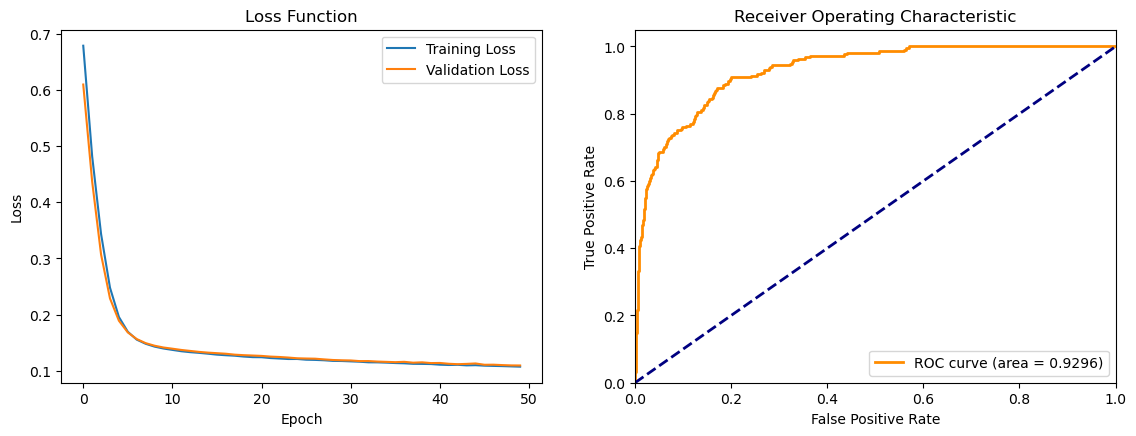

In [47]:
# Plot loss and roc curve
plot_loss_and_roc(train_results, model, X_test, y_test, batch_size=512)

In [48]:
# Evaluation
eval = model.evaluate(X_test, y_test, batch_size=512)

# Test (with oversampled data, only positives)
eval_positives = model.evaluate(X_test[y_test==1], y_test[y_test==1], batch_size=512)

print(f"\nEval - Test loss: {eval[0]:.4}, Test metric: {eval[1]:.4}")
print(f"Eval positives only- Test loss: {eval_positives[0]:.4}, Test metric: {eval_positives[1]:.4}")

8/8 [==============================] - 0s 1ms/step - loss: 0.1269 - mse: 0.0356


1/1 [==============================] - 0s 21ms/step - loss: 1.6034 - mse: 0.5128

Eval - Test loss: 0.1269, Test metric: 0.03558
Eval positives only- Test loss: 1.603, Test metric: 0.5128


In [49]:
print("Predicting...")
prediction = predict_values(df_model_copy, model_columns_numerical, model, batch_size=512)


Predicting...
7071/7071 [==============================] - 5s 647us/step


In [50]:
print("\nExporting...")
export_prediction(data=feather, region_column=region_column, out_name=model_name, prediction=prediction, filter_value=None)


Exporting...
Loading data...
Converting prediction...
Creating geodataframe...
Exporting raster...

Number of threads rasterizing: 48


Rasterizing: 100%|██████████| 1/1 [05:56<00:00, 356.65s/it]


### **M3:** ANN with random sampling and SMOTETomek

**M3D:** Train/test split first, afterwards oversampling with Batch Norm

In [36]:
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Strategy 3: Random Sampling, then split into training and test data, afterwards SMOTETomek oversampling positives/downsampling negatives
X_rs, y_rs = select_random_samples(X_imputed, y_imputed, sampling_strategy=0.1, sampling_class="negatives", seed=seed)
X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size=0.1, random_state=seed)

tomek = TomekLinks(sampling_strategy="majority")
X_rs_smotet, y_rs_smotet = SMOTETomek(sampling_strategy=0.5, tomek=tomek, random_state=seed).fit_resample(X_train, y_train)
print(f"Training dataset shape {Counter(y_rs_smotet)}")
print(f"Test dataset shape {Counter(y_test)}")

X_train = tf.convert_to_tensor(X_rs_smotet, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_rs_smotet, dtype=np.int8)

epochs = 50
batch_size = 512

model_name = "BASELINE_ANN_M3C_I_" + str(epochs) + "_EPOCHS_" + str(batch_size) + "_BATCH_SIZE"

# Model
model = create_simple_ann(num_features=X_train.shape[1], model_name=model_name, hidden_units=1, activation=tf.keras.activations.relu, batch_norm=True, seed=seed)

# Callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5), tensorboard_callback(model_log_folder, model_name)] 

# Training
train_results = train_ann(X_train, y_train, model, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks, seed=seed, verbose=0)

# Save model
save_model(model, model_name)


Subset dataset shape Counter({0.0: 361828, 1.0: 1854})
Training dataset shape Counter({0.0: 325669, 1.0: 162836})
Test dataset shape Counter({0.0: 36156, 1.0: 213})
Saving TensorBoard log files to: logs\BASELINE_ANN_M3C_I_50_EPOCHS_512_BATCH_SIZE_20240208-153253
Random seed: 42, precision: float32

Training on 390804 samples.



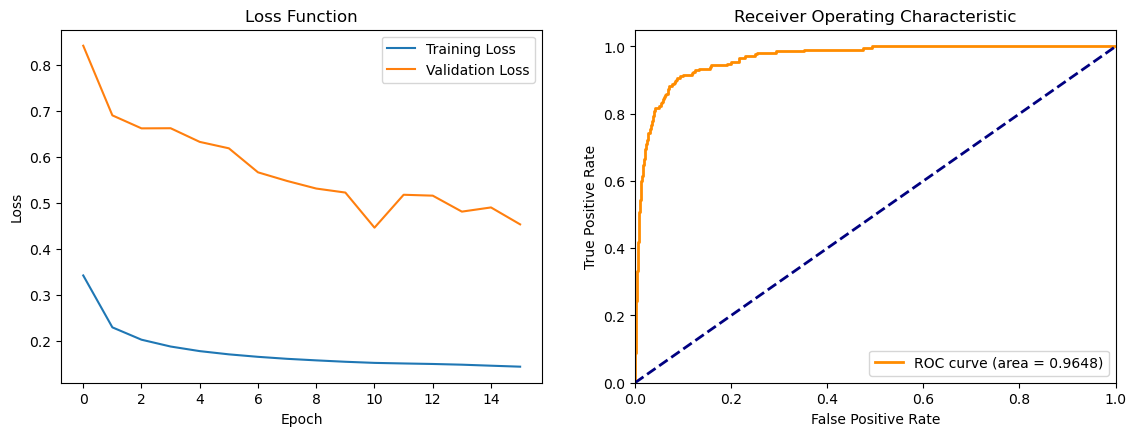

In [37]:
# Plot loss and roc curve
plot_loss_and_roc(train_results, model, X_test, y_test, batch_size=512)


In [38]:
# Evaluation
# Test (with oversampled data)
eval = model.evaluate(X_test, y_test, batch_size=512)

# Test (with oversampled data, only positives)
eval_positives = model.evaluate(X_test[y_test==1], y_test[y_test==1], batch_size=512)

print(f"\nEval - Test loss: {eval[0]:.4}, Test metric: {eval[1]:.4}")
print(f"Eval positives only- Test loss: {eval_positives[0]:.4}, Test metric: {eval_positives[1]:.4}")

1/1 [==============================] - 0s 24ms/step - loss: 0.6403 - mse: 0.1910

Eval - Test loss: 0.08293, Test metric: 0.02346
Eval positives only- Test loss: 0.6403, Test metric: 0.191


In [39]:
print("Predicting...")
prediction = predict_values(df_model_copy, model_columns_numerical, model, batch_size=512)


Predicting...
7071/7071 [==============================] - 5s 687us/step


In [40]:
print("\nExporting...")
export_prediction(data=feather, region_column=region_column, out_name=model_name, prediction=prediction, filter_value=None)


Exporting...
Loading data...
Converting prediction...
Creating geodataframe...
Exporting raster...

Number of threads rasterizing: 48


Rasterizing: 100%|██████████| 1/1 [05:55<00:00, 355.38s/it]
